In [ ]:
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16
#mpl.rcParams['image.cmap'] = 'jet'
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# general
import numpy as np
import time, sys

# slide stuff
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/raid2/rgast/anaconda3/envs/mne_presentation/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "simple",
              "transition": "zoom",
              "start_slideshow_at": "selected",
})

# analysis
import mne

<center><font color="blue">Brain Stimulation Workshop, 02.02.18</font>
-----------------------------------------------------------------------
<br><center>
    
Extrinsic Stimulation of Neural Mass Models
=======================

<br><br><center>
*<font color="blue">MEG and Cortical Networks Group, MPI CBS Leipzig</font>*

<font color="blue">Personal PhD Project:
----------------------------------------
    
**Neural modeling of motor circuits: Fusing physiological data, structural MRI, functional MRI and EEG**

<img src="img/BGTC_circuit.png" width=1000>

<font color="blue">Planned Collaborations:
------------------------------------------

1. With **Konstantin Weise**: *Modeling D- and I-waves elicitid by TMS of M1 using neural mass models (NMMs)*

2. With **Ruxue Gong**: *Predicting efficient stimulation sites and timings for beta oscillation suppression in Parkinson's disease via NMMs*

<img src="img/DiLazzaro_2014.png" width=500 ALIGN="right">

<font color="blue">Modeling D- and I-waves with NMMs:
-----------------------------------------------------

**Describing the challenges** 

* <font size=5>D- and I-waves are tightly timed, subsequent volleys of excitation traveling down the corticospinal axons (of M1 Betz cells) after TMS stimulation of M1

* <font size=5>Range of observations reported regarding the occurence, amplitude and timing of these D-/I-waves for different stimulation set-ups

* <font size=5>Hypothesized to result from feedback loops within M1 -> motivates investigation via NMMs

In [509]:
from core.circuit import JansenRitLeakyCapacitorCircuit

AMPA = {'tau_rise': 3e-4, 'tau_decay': 6e-3}
GABAA = {'tau_rise': 6e-4}
axon = {'max_firing_rate': 670.}

circuit = JansenRitLeakyCapacitorCircuit(step_size=1e-3, max_synaptic_delay=0.15, synapse_params=[AMPA, GABAA],
                                         axon_params=[axon for i in range(3)], connectivity_scaling=135.*5/670)

<IPython.core.display.Javascript object>


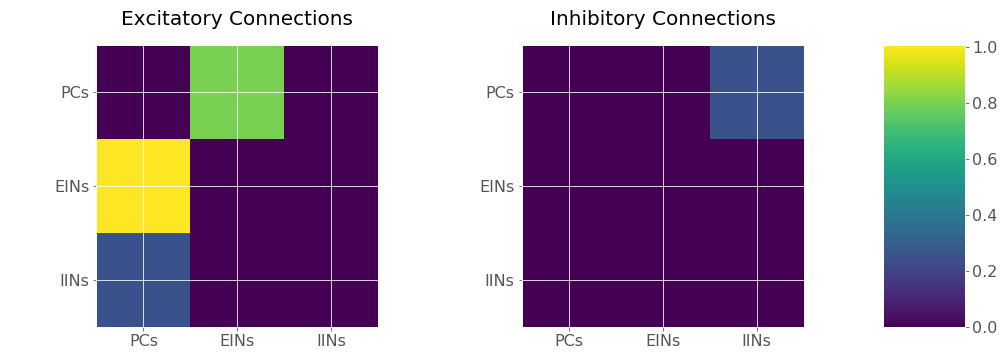

In [510]:
# basic parameters
n_populations = 3
n_synapses = 2

# plot circuit connectivity
###########################

c = 135*5/670
fig1, axes = plt.subplots(1,3, figsize=(14,5), gridspec_kw = {'width_ratios':[5, 5, 1]})
ax1 = axes[0]
m = ax1.matshow(np.squeeze(circuit.C[:, :, 0]), clim=[0, c])
ax1.xaxis.set_ticks_position('bottom')
ax1.set_xticklabels(['', 'PCs', 'EINs', 'IINs'])
ax1.set_yticklabels(['', 'PCs', 'EINs', 'IINs'])
ax1.set_title('Excitatory Connections')
ax2 = axes[1]
ax2.matshow(np.squeeze(circuit.C[:, :, 1]), clim=[0, c])
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xticklabels(['', 'PCs', 'EINs', 'IINs'])
ax2.set_yticklabels(['', 'PCs', 'EINs', 'IINs'])
ax2.set_title('Inhibitory Connections')
ax3 = axes[2]
fig2.colorbar(m, cax=ax3, orientation='vertical')
plt.tight_layout()

In [ ]:
#fig1
fig, axes = plt.subplots(figsize=(14,5))
axes = circuit.populations[0].axon.plot_transfer_function(create_plot=False, axes=axes)

In [ ]:
# simulation parameters
#######################

# simulation duration
simulation_time = 1.
simulation_steps = int(simulation_time / circuit.step_size)

# extrinsic input
ext_inp_onset = 0.2
ext_inp_dur = 0.001

time_points = np.arange(0., ext_inp_dur, circuit.step_size)
impulse = 3e-20 * np.cos(time_points * .1 * 2 * np.pi) + 5e-13

impact_on_pop = np.array([1., .0, .0])

extrinsic_input = np.zeros((simulation_steps, n_populations))
inp_start = int(ext_inp_onset / circuit.step_size)
inp_end = inp_start + int(ext_inp_dur / circuit.step_size)
for i in range(n_populations):
    extrinsic_input[inp_start:inp_end, i] = ext_inp_weights[i] * impulse

# perform simulation
####################

circuit.clear()
circuit.run(np.zeros((simulation_steps, n_populations, n_synapses)), simulation_time, extrinsic_input)

In [ ]:
# plot resulting membrane potential traces
##########################################

fig2, ax1 = plt.subplots(figsize=(14,6))
pc_psp = circuit.get_population_states(0, [0])
pc_fr = circuit.populations[0].axon.compute_firing_rate(pc_psp)
ax1.plot(pc_psp)
#ax1.set_ylabel('Firing Rate [Hz]') 
ax1.set_ylabel('Membrane Potential [V]') 
ax2 = ax1.twinx()
ax2.plot(extrinsic_input[:, 0], 'b', alpha=0.3)
ax2.set_ylabel('Extrinsic Current [A]')

**Questions/Difficulties in modeling TMS effects on M1 with NMMs:**

* Reformulating the D- and I-wave questions/expectations to fit the neural mass modeling formalism

* Coupling model: What does a certain neural population actually "feel" from the macroscopic TMS induced E-field?

* Identifying the model parameters/mechanisms crucial to replicate the time-window of the 670 Hz output (D- and I-waves)

<font color="blue">Modeling TMS effects on the BGTC circuit to investigate beta oscillation suppression in Parkinson's disease
--------------------------------------------------------------------------------------------------------------------------
    
**Basic idea:**

* Using the NMM model of the BGTC circuit to predict TMS effects on its dynamics

* Focus on beta oscillations in the Parkinsonian BGTC circuit

* Which stimulation sites/timings are most effective in counteracting pathological behavior?

* Do we see long-term effects when implementing long-term plasticity mechanisms?

In [ ]:
simulation_time = 0.5
simulation_steps = int(simulation_time / circuit.step_size)

synaptic_input = np.zeros((simulation_steps, n_populations, n_synapses))
synaptic_input[:, 0, 0] = 22. * np.random.randn(simulation_steps) + 220.

# extrinsic input
ext_inp_onset = 0.25
ext_inp_dur = 0.015

time_points = np.arange(0., ext_inp_dur, circuit.step_size)
impulse = 1e-20 * np.cos(time_points * .1 * 2 * np.pi) + 3e-13

impact_on_pop = np.array([1., .0, .0])

extrinsic_input = np.zeros((simulation_steps, n_populations))
inp_start = int(ext_inp_onset / circuit.step_size)
inp_end = inp_start + int(ext_inp_dur / circuit.step_size)
for i in range(n_populations):
    extrinsic_input[inp_start:inp_end, i] = ext_inp_weights[i] * impulse

circuit.clear()
circuit.run(synaptic_input, simulation_time, extrinsic_input)

In [ ]:
# plot resulting membrane potential traces
##########################################

fig3, ax1 = plt.subplots(figsize=(14,5))
ax1 = circuit.plot_population_states([0], create_plot=False, axes=ax1)
ax1.set_ylabel('Membrane Voltange [V]')
ax2 = ax1.twinx()
ax2.plot(extrinsic_input[:, 0], 'b', alpha=0.3)
ax2.set_ylabel('Extrinsic Current [A]')

In [ ]:
# input parameters
ext_inp_onsets = np.arange(0.25, 0.36, 0.001)

pc_states = list()
inputs = list()

for ext_inp_onset in ext_inp_onsets:
    
    # condition
    inp_start = int(ext_inp_onset / circuit.step_size)
    inp_end = inp_start + int(ext_inp_dur / circuit.step_size)
    extrinsic_input = np.zeros((simulation_steps, n_populations))
    extrinsic_input[inp_start:inp_end, 0] = impulse
    
    # simulation
    circuit.clear()
    circuit.run(synaptic_input, simulation_time, extrinsic_input)
    
    # get results
    pc_states.append(circuit.get_population_states(0, [0], time_window=[0.15, simulation_time]))
    inp = (extrinsic_input[int(0.15 / circuit.step_size):, 0] > 0.) - 0.075
    inp[inp >= 0.] = -0.0725
    inputs.append(inp)
    
# reference data
circuit.clear()
circuit.run(synaptic_input, simulation_time)
reference = circuit.get_population_states(0, [0], time_window=[0.15, simulation_time])

<IPython.core.display.Javascript object>


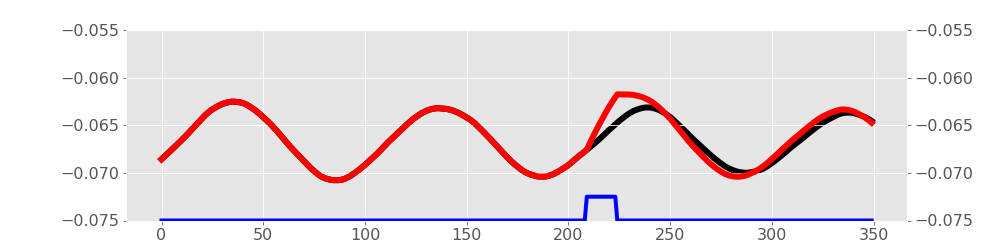

In [512]:
fig, ax = plt.subplots(figsize=(14,3.5))
plt.ion()
ax.plot(reference, linewidth=6, color='black')
ax.set_ylim(-0.075, -0.055)
fig.show()
fig.canvas.draw()

ax2 = ax.twinx()
for states, inp in zip(pc_states, inputs):
    ax2.clear()
    ax2.plot(states, linewidth=6, color='red')
    ax2.plot(inp, color='blue')
    ax2.set_ylim(-0.075, -0.055)
    fig.canvas.draw()
    time.sleep(.1)

<center><font color="blue">Thank you
====================================